In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dow_jones_tickers = si.tickers_dow()
print(dow_jones_tickers)


['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


In [3]:
dow_jones_tickers

['AAPL',
 'AMGN',
 'AXP',
 'BA',
 'CAT',
 'CRM',
 'CSCO',
 'CVX',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KO',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'V',
 'VZ',
 'WBA',
 'WMT']

In [4]:
data_table=[]
for ticker in dow_jones_tickers:
    data_table.append(si.get_data(ticker,'2021-08-20')['close'].values)
arr = np.array(data_table).transpose()
df = pd.DataFrame(arr, columns = dow_jones_tickers)
df.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,148.190002,223.529999,159.750000,212.669998,204.940002,256.130005,58.220001,94.300003,175.119995,60.889999,...,78.680000,304.359985,167.789993,145.089996,160.839996,429.709991,231.360001,55.520000,48.299999,151.449997
1,149.710007,225.639999,160.449997,219.399994,209.139999,260.519989,58.540001,96.730003,177.660004,62.060001,...,78.379997,304.649994,169.720001,144.350006,159.899994,425.359985,234.139999,55.419998,48.509998,150.449997
2,149.619995,224.380005,161.199997,221.429993,212.589996,259.660004,59.320000,97.839996,178.470001,63.259998,...,77.720001,302.619995,169.979996,143.179993,160.639999,423.410004,234.240005,55.009998,48.340000,148.899994
3,148.360001,221.589996,166.179993,221.029999,214.759995,260.850006,59.349998,98.510002,178.309998,63.869999,...,77.070000,302.010010,169.839996,142.669998,162.580002,419.739990,232.589996,54.930000,48.650002,148.960007
4,147.539993,221.470001,165.509995,216.500000,211.240005,267.790009,59.200001,97.220001,176.559998,63.650002,...,76.570000,299.089996,166.919998,142.419998,159.970001,416.850006,230.520004,54.599998,47.840000,147.350006


In [6]:
dow_divisor=0.1517275
price_data=df.to_numpy()
dow_index=(np.sum(price_data,axis=1)/dow_divisor)

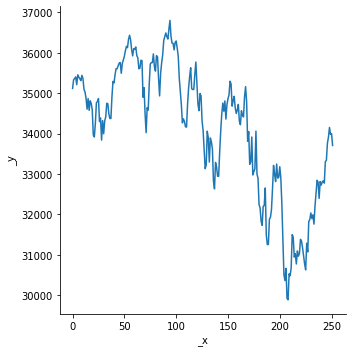

In [7]:
g = sns.relplot(x=range(0,len(dow_index)),y=dow_index, kind="line")

In [8]:
risk_free_rate=0.0288

In [9]:
def sharpe_ratio_calc(data,risk_free_rate):
    sharpe_ratio=((data[-1]-data[0])/data[0]-risk_free_rate)/np.std((data[1:]-data[0:-1])/data[0:-1])
    return sharpe_ratio

In [10]:
print(sharpe_ratio_calc(dow_index,risk_free_rate))

-6.400758671866319


In [45]:
def price_adjustment(price_data,new_weight):
    total_capital=np.sum(price_data[0,:])
    new_weight[new_weight<0]=0.001
    new_weight=new_weight/sum(new_weight)
    adjusted_price=price_data*(new_weight*total_capital/price_data[0,:])
    price=(np.sum(adjusted_price,axis=1)/dow_divisor)
    return price, new_weight


In [48]:
def evaluate(price_data,new_weight):
    price,w=price_adjustment(price_data,new_weight)
    return sharpe_ratio_calc(price,risk_free_rate)

In [13]:
def selection(weight,score,population):
    return weight[np.argsort(score)[int(population/2):],:]

In [21]:
def crossover(new_parents):
    pairs=np.split(new_parents,2)
    children=np.zeros(new_parents.shape)
    counter=0

    for i in range(pairs[0].shape[0]):
        position=np.random.choice(pairs[0].shape[1], int(pairs[0].shape[1]/2))
        p1=pairs[0][i]
        p2=pairs[1][i]
        children[counter,:]=p1
        children[counter,position]=p2[position]
        counter+=1
        children[counter,:]=p2
        children[counter,position]=p1[position]
        counter+=1
    
    return children

In [41]:
def mutation(children):
    mutation_rate=0.5
    for i in range(children.shape[0]):
        for j in range(children.shape[1]):
            if np.random.rand()>mutation_rate:
                children[i,j]=children[i,j]*(1+np.random.randint(-1000,1000)/10000)
    return children

In [64]:
population=100
new_population=np.random.rand(population,30)
sharpe_ratio=np.zeros((population))
num_gen=100
for k in range(num_gen):
    for i in range(population):
        sharpe_ratio[i]=evaluate(price_data,new_population[i,:])

    new_parents=selection(new_population,sharpe_ratio,population)
    children=crossover(new_parents)
    children=mutation(children)
    new_population=np.vstack((new_parents,children))
    

for i in range(population):
    sharpe_ratio[i]=evaluate(price_data,new_population[i,:])

index=np.argmax(sharpe_ratio)
new_weight=new_population[index,:]
new_price,percentage=price_adjustment(price_data,new_weight)

In [65]:
print(sharpe_ratio[index])
print(percentage)

32.2116494062456
[1.80586813e-02 1.54278784e-02 4.61144264e-05 2.77259033e-03
 1.73315916e-03 6.12859911e-04 2.38637409e-03 7.88614196e-01
 4.83786519e-04 2.06667913e-03 1.06296022e-03 5.68543371e-03
 5.22424743e-04 7.42264643e-03 1.86204944e-03 5.81290552e-04
 1.68257760e-03 1.89898680e-02 1.59174550e-02 1.28180076e-03
 2.29298417e-02 4.59115870e-03 8.17804781e-04 2.47336409e-03
 6.49446315e-04 7.76835720e-02 2.78038847e-04 2.33237621e-03
 5.36387551e-04 4.97183770e-04]


In [68]:
#没有优化的收益
print((dow_index[-1]-dow_index[0])/dow_index[0]*100)
#优化后的收益
print((new_price[-1]-new_price[0])/new_price[0]*100)


-4.013854780283731
56.08752022686028


<AxesSubplot:>

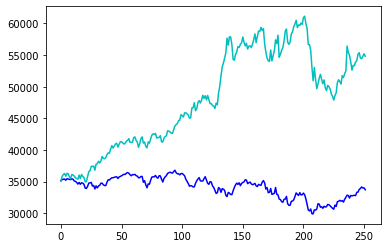

In [66]:
fig, ax = plt.subplots()
sns.lineplot(x=range(0,len(dow_index)),y=dow_index,color='b')
sns.lineplot(x=range(0,len(dow_index)),y=new_price,color='c')